In [1]:
import sys
sys.path.append('../src/')
import os
import math
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from models import *
from priors import *
from utils import *

In [3]:
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/ChestX-ray14_long_range.csv')
# Take mean of each random seed at each dataset size
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()

In [4]:
index = 2
X_train, y_train, X_test, y_test = split_df(df, index=index)
model, losses = train_Arctan(X_train, y_train)
model.eval()

../src/models.py:140: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  loss = 2**torch.range(1, 5, device=y.device)@loss_func(output, y)


Arctan(
  (softplus): Softplus(beta=1, threshold=20)
)

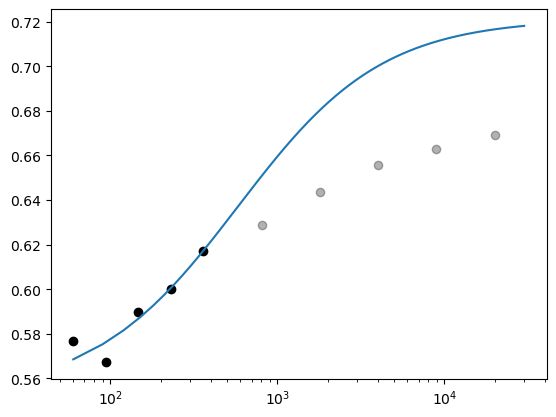

In [5]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    loc = model(torch.linspace(60, 30000, 1000))
plt.scatter(X_train, y_train, color='black', alpha=1.0, label='Initial subsets')
plt.scatter(X_test, y_test, color='black', alpha=0.3, label='Ground truth')
plt.plot(np.linspace(60, 30000, 1000), loc, color='#1f77b4', label='Gaussian process (ours)')
plt.xscale('log')
plt.show()

In [4]:
plt.plot(list(range(len(losses))), losses)
plt.show()

NameError: name 'losses' is not defined

In [4]:
index = 2
X_train, y_train, X_test, y_test = split_df(df, index=index)
likelihood, model, losses = train_GPArctan(X_train, y_train)
likelihood.eval()
model.eval()

GPArctan(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (noise_std_prior): TruncatedNormalPrior()
  (mean_module): ArctanPriorMean(
    (softplus): Softplus(beta=1, threshold=20)
    (epsilon_prior): EpsilonPrior()
  )
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (lengthscale_prior): TruncatedNormalPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (outputscale_std_prior): TruncatedNormalPrior()
)

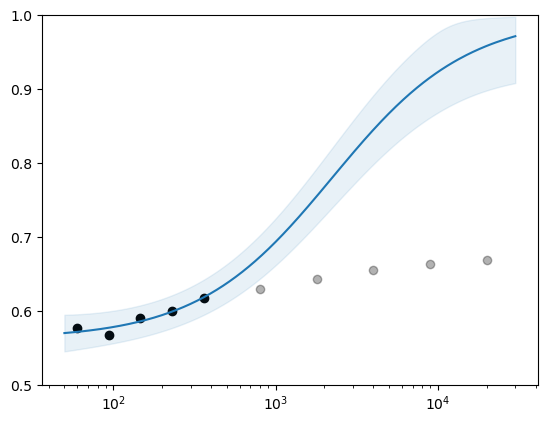

In [5]:
with torch.no_grad():
    linspace = torch.linspace(50, 30000, 29950)
    observed_pred = likelihood(model(linspace))
loc = observed_pred.mean.numpy()
scale = observed_pred.stddev.numpy()
lower, upper = truncated_normal_uncertainty(0, 1, loc, scale)
plt.scatter(X_train, y_train, color='black', alpha=1.0, label='Initial subsets')
plt.scatter(X_test, y_test, color='black', alpha=0.3, label='Ground truth')
plt.plot(np.linspace(50, 30000, 29950), loc, color='#1f77b4', label='Gaussian process (ours)')
plt.fill_between(np.linspace(50, 30000, 29950), lower, upper, color='#1f77b4', alpha=0.1)
plt.ylim([0.5,1.0])
plt.xscale('log')
plt.show()

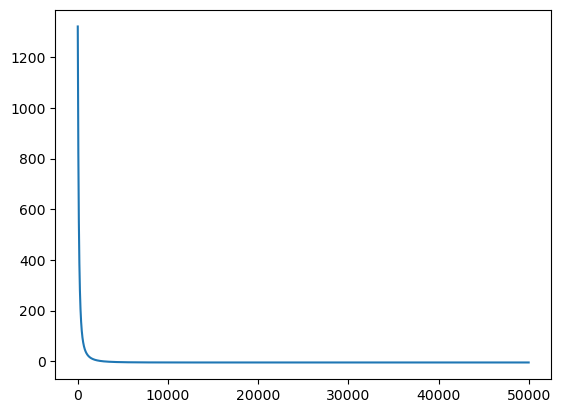

In [6]:
plt.plot(list(range(len(losses))), losses)
plt.show()